In [38]:

from qiskit_mps_initializer.datatypes import QuantumState
from qiskit import QuantumCircuit
import quimb.gates as gates
import numpy as np
import matplotlib.pyplot as plt

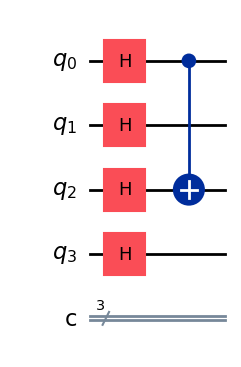

In [39]:
n=4
qc= QuantumCircuit(n, 3)
for i in range(n):
    qc.h(i)
qc.cx(0, 2)
qc.draw(output='mpl')

In [40]:


vec = np.array([1, 0, 0, 0], dtype=complex)  # |00⟩ state in vector form

qs = QuantumState(state=vec,original_data=vec)

print(qs.size)


4


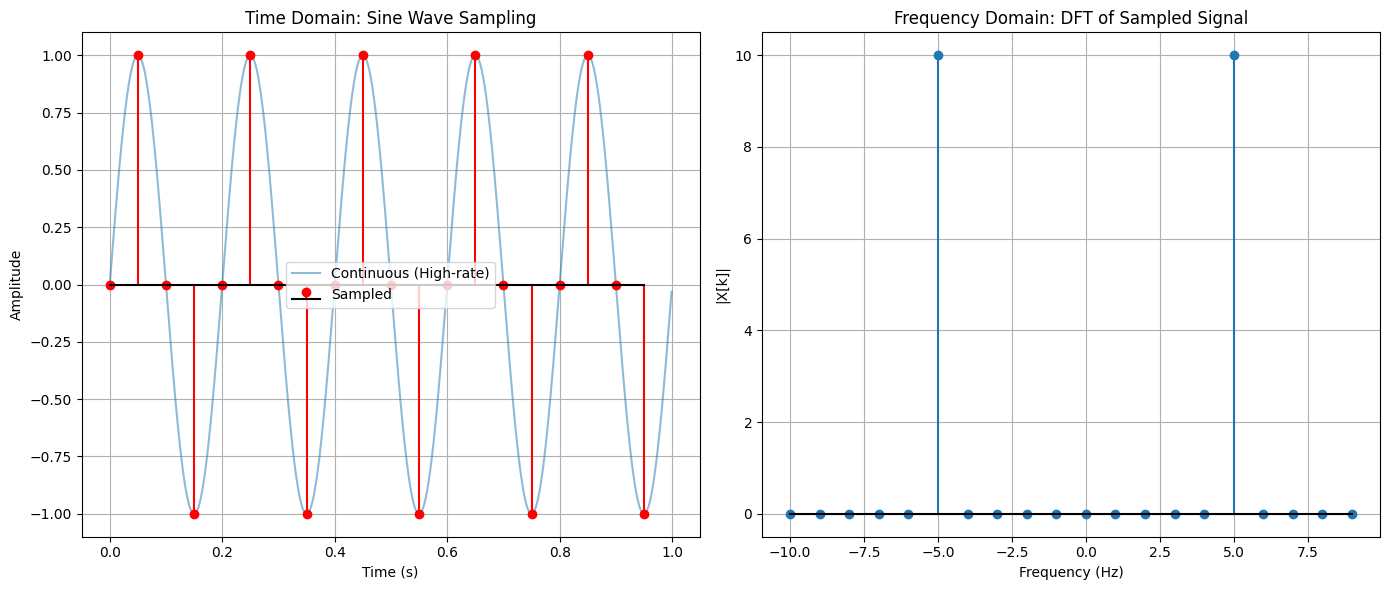

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Create a "continuous-like" sine wave
f = 5                 # Frequency of sine wave (Hz)
T = 1                 # Duration in seconds
Fs_high = 1000        # High sampling rate (for continuous approximation)
t_high = np.linspace(0, T, int(Fs_high*T), endpoint=False)
x_continuous = np.sin(2 * np.pi * f * t_high)

# 2. Simulate sampling the continuous signal
Fs = 20               # Sampling frequency (Hz)
t_sampled = np.linspace(0, T, int(Fs*T), endpoint=False)
x_sampled = np.sin(2 * np.pi * f * t_sampled)

# 3. Compute DFT of sampled signal
X = np.fft.fft(x_sampled)
N = len(x_sampled)
freqs = np.fft.fftfreq(N, d=1/Fs)

# Shift for plotting
X_magnitude = np.abs(np.fft.fftshift(X))
freqs_shifted = np.fft.fftshift(freqs)

# 4. Plotting

plt.figure(figsize=(14, 6))

# Time domain comparison
plt.subplot(1, 2, 1)
plt.plot(t_high, x_continuous, label='Continuous (High-rate)', alpha=0.5)
plt.stem(t_sampled, x_sampled, linefmt='r-', markerfmt='ro', basefmt='k', label='Sampled')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Time Domain: Sine Wave Sampling')
plt.legend()
plt.grid(True)

# Frequency domain
plt.subplot(1, 2, 2)
plt.stem(freqs_shifted, X_magnitude, basefmt="k")  # no use_line_collection
plt.xlabel('Frequency (Hz)')
plt.ylabel('|X[k]|')
plt.title('Frequency Domain: DFT of Sampled Signal')
plt.grid(True)

plt.tight_layout()
plt.show()


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.visualization import plot_state_city

# Define statevector
psi = np.array([1, 2, 1, 2, 7, 8, 0, 1], dtype=complex)
psi /= np.linalg.norm(psi)

# Create QuantumState and circuit
state = QuantumState.from_dense_data(psi)
circuit = state.generate_mps_initializer_circuit(number_of_layers=7)

# Set backend
backend = Aer.get_backend('statevector_simulator')

# Transpile and run
t_circuit = transpile(circuit, backend)
job = backend.run(t_circuit)
result = job.result()

# Get output statevector
output_statevector = result.get_statevector()

print("Original statevector:\n", psi)
print("\nPrepared statevector:\n", output_statevector)



DEBUG LOG: MPS initializer generator was called. This log is for the purpose of reducing the number of calls to this function.


Original statevector:
 [0.08980265+0.j 0.1796053 +0.j 0.08980265+0.j 0.1796053 +0.j
 0.62861856+0.j 0.71842121+0.j 0.        +0.j 0.08980265+0.j]

Prepared statevector:
 Statevector([ 0.16904607+0.j,  0.02608897+0.j,  0.22229117+0.j,
              0.09288773+0.j,  0.9499289 +0.j, -0.00458367+0.j,
              0.01909287+0.j,  0.09975388+0.j],
            dims=(2, 2, 2))


Fidelity between original and prepared states: 0.434703


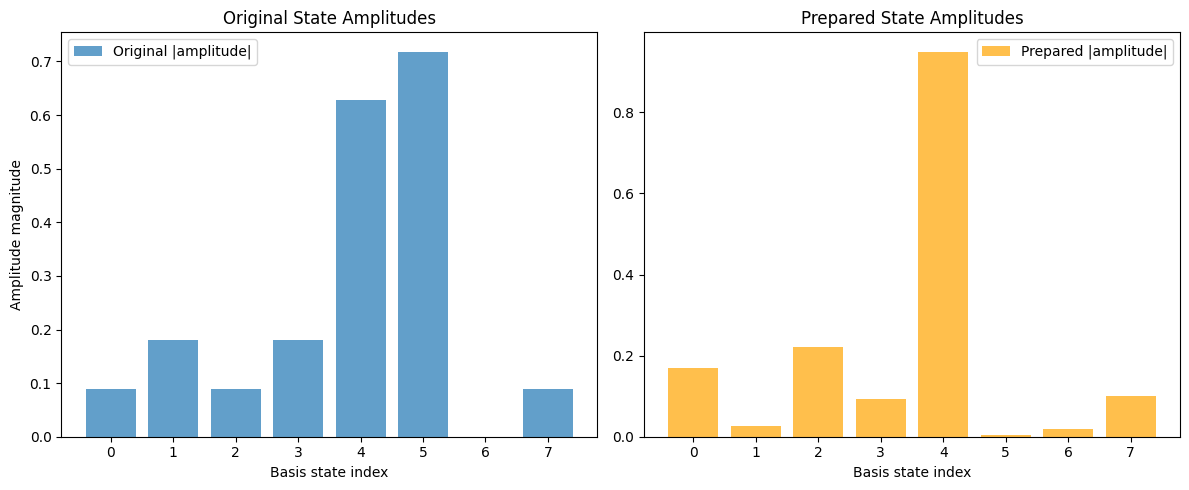

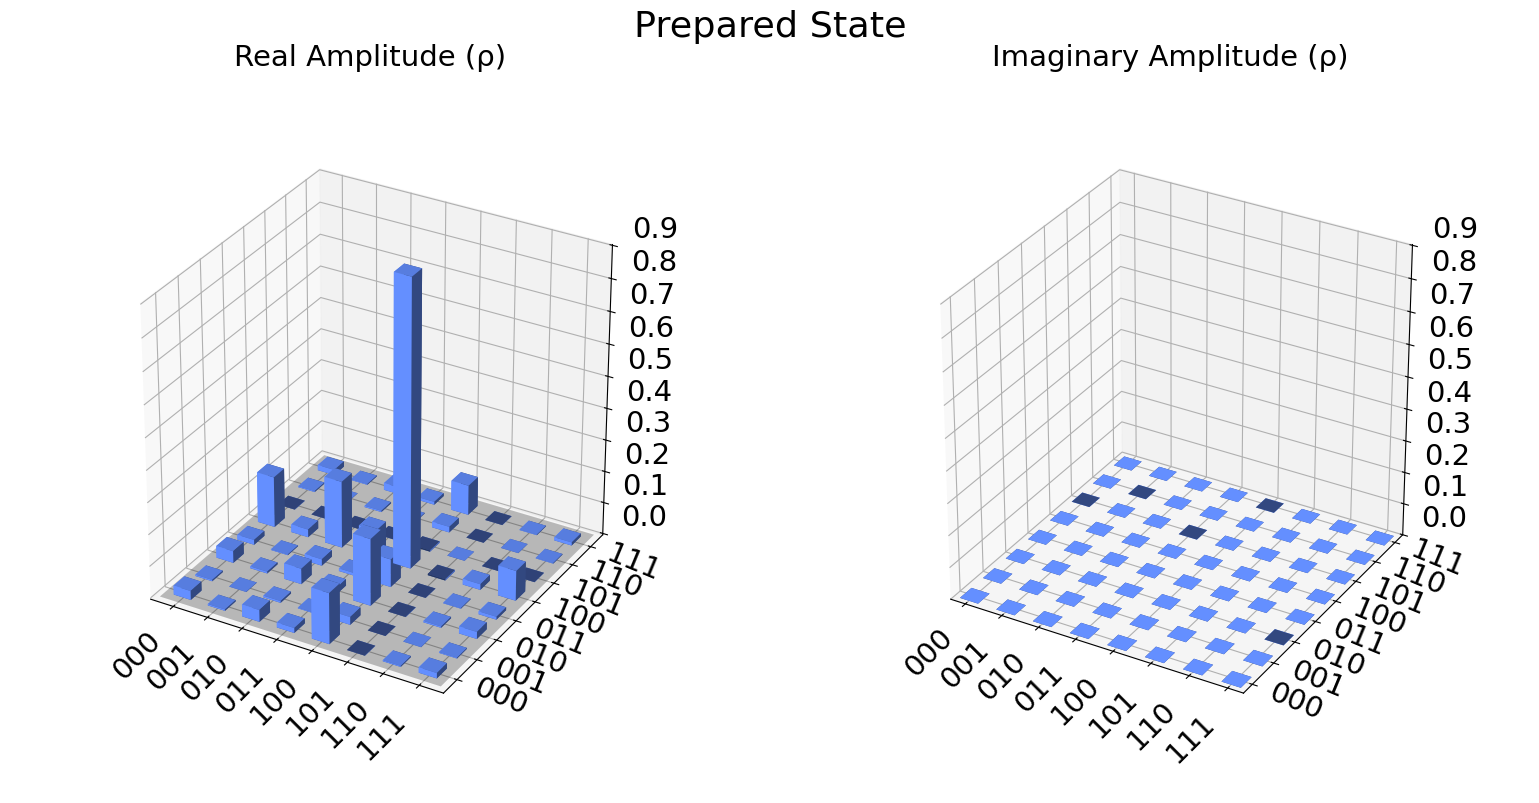

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_city

# Your original and prepared statevectors (numpy and Qiskit Statevector)
original_sv = Statevector(psi)
prepared_sv = output_statevector

# Compute fidelity
fidelity = abs(original_sv.data.conj().dot(prepared_sv.data))**2
print(f"Fidelity between original and prepared states: {fidelity:.6f}")

# Plot amplitudes comparison
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.bar(range(len(original_sv.data)), np.abs(original_sv.data), alpha=0.7, label='Original |amplitude|')
plt.title('Original State Amplitudes')
plt.xlabel('Basis state index')
plt.ylabel('Amplitude magnitude')
plt.legend()

plt.subplot(1,2,2)
plt.bar(range(len(prepared_sv.data)), np.abs(prepared_sv.data), alpha=0.7, color='orange', label='Prepared |amplitude|')
plt.title('Prepared State Amplitudes')
plt.xlabel('Basis state index')
plt.legend()

plt.tight_layout()
plt.show()

# Use Qiskit visualization to plot city plots (amplitudes and phases)
plot_state_city(original_sv, title="Original State")
plot_state_city(prepared_sv, title="Prepared State")


In [44]:
import scipy as sp
import quimb.tensor as qtn
mps = qtn.MatrixProductState.from_dense(psi, max_bond=2)
import quimb as qu

def G_matrices(mps: qtn.MatrixProductState) -> list[qu.qarray]:
    G = []

    A0 = mps[0]
    A0.data
    A0_vec = np.array([A0.data.flatten()])
    print(A0_vec)


    G0 = np.concatenate((
        A0_vec.T, sp.linalg.null_space(A0_vec).conjugate()
    ), axis=1)
    print(G0)
    G.append(G0)

    for i in range(1, mps.num_tensors - 1):
        Ai = mps[i]
        Ai_a_0 = Ai.data[0, :, :].flatten()
        Ai_a_1 = Ai.data[1, :, :].flatten()
        Gi_incomplete = np.array([Ai_a_0, Ai_a_1])
        Gi = np.concatenate((
        Gi_incomplete.T,
        sp.linalg.null_space(Gi_incomplete).conjugate()
        ), axis=1)
    print(Gi)
    G.append(Gi) 

    G_last = mps[-1].data.T
    G.append(G_last)
    print(G_last)
    return G


# Print the G matrices


# Optional: make printing cleaner
np.set_printoptions(precision=8, suppress=True)









In [45]:
def bond2_mps_approximation(psi: qu.qarray, normalize=True) -> qtn.MatrixProductState:
        
    if not np.isclose(np.linalg.norm(psi), 1.0):
        raise ValueError("The state vector must be normalized. The norm was: " + str(np.linalg.norm(psi)))
        
    mps = qtn.MatrixProductState.from_dense(psi, max_bond=2)

    if normalize:
        mps.normalize()

    mps.right_canonicalize(inplace=True)

    bond_sizes = mps.bond_sizes()
    # check if any of the bond sizes are 1
    if any([bond_size != 2 for bond_size in bond_sizes]):
        raise ValueError("The bond sizes of the MPS should be exactly 2.")

    return mps

def G_matrices(mps: qtn.MatrixProductState) -> list[qu.qarray]:
    # TODO: things probably can be done more efficiently in terms of not transposing data around and working properly in the numpy realm

    G = []

    # G_first
    A0 = mps[0]
    A0_vec = np.array([A0.data.flatten()])
    G0 = np.concatenate((A0_vec.T, sp.linalg.null_space(A0_vec).conjugate()), axis=1)
    G.append(G0)

    # G_middle
    for i in range(1, mps.num_tensors-1):
        Ai = mps[i]
        Ai_a_0 = Ai.data[0, :, :].flatten()
        Ai_a_1 = Ai.data[1, :, :].flatten()
        Gi_incomplete = np.array([Ai_a_0, Ai_a_1])
        Gi = np.concatenate((Gi_incomplete.T, sp.linalg.null_space(Gi_incomplete).conjugate()), axis=1)
        Gi = Gi @ np.real(gates.SWAP)
        G.append(Gi)

    # G_last
    G_last = mps[-1].data.T
    G.append(G_last)
    
    # TODO: maybe also check the equivalence of the product of the G matrices with the original MPS

    return G

def one_layer_gates_for_bond2_approximated(G: list[qu.qarray]) -> list:
    # this implicitly checks for the unitarity of the G matrices
    return [qiskit.circuit.library.UnitaryGate(Gi) for Gi in G]

def multi_layered_circuit_for_non_approximated(psi: qu.qarray, number_of_layers: int) -> qiskit.QuantumCircuit:

    # check for normalization of psi
    if not np.isclose(np.linalg.norm(psi), 1.0):
        raise ValueError("The state vector must be normalized. The norm was: " + str(np.linalg.norm(psi)))
    
    number_of_qubits = int(np.log2(len(psi)))
    if len(psi) != 2**number_of_qubits:
        raise ValueError("The state vector must have a size of 2^n.")

    current_psi = np.copy(psi)
    current_psi = current_psi / np.linalg.norm(current_psi)
    print("0")
    print(current_psi)

    layers = []
    for j in range(number_of_layers):
        mps = bond2_mps_approximation(current_psi)
        approximated_psi = mps.to_dense()
        G = G_matrices(mps)

        current_layer_circuit = qiskit.QuantumCircuit(number_of_qubits)
        for i in range(len(G)-1):
            current_layer_circuit.unitary(G[i], [number_of_qubits-1-i-1 , number_of_qubits-1-i])
        current_layer_circuit.unitary(G[-1], [0])

        unitary = qiskit.quantum_info.Operator.from_circuit(current_layer_circuit).data

        current_psi = unitary.conjugate().T @ current_psi
        current_psi = current_psi / np.linalg.norm(current_psi)
        print(str(j+1))
        print(np.abs(current_psi))
        # print(np.abs(unitary.conjugate().T @ approximated_psi).T)

        layers.append(current_layer_circuit)

    # the order of the construction of the layers is the reverse of the order of the application of them in the implementation
    layers.reverse()
    circuit = qiskit.QuantumCircuit(number_of_qubits)
    for layer in layers:
        circuit.compose(layer, inplace=True)

        

    # G = G_matrices(bond2_mps_approximation(psi))
    # for i in range(len(G)-1):
    #     circuit.unitary(G[i], [number_of_qubits-1-i-1 , number_of_qubits-1-i])
    # circuit.unitary(G[-1], [0])

    # TODO: make this multi-layered

    return circuit

In [46]:
def plot_wavefunction(psi, plot_size_scale=1, normalize=True):
    abs_part = np.abs(psi)
    if normalize:
        abs_part = abs_part / np.linalg.norm(abs_part)
    phase_part = np.angle(psi)

    num_of_basis = len(abs_part)
    num_of_qubits = (num_of_basis-1).bit_length()
    x_axis = np.arange(num_of_basis)

    ket_labels = [rf'$|{np.binary_repr(x, width=num_of_qubits)}\rangle$' for x in x_axis]
    # example:
    # KET_LABELS = [r'$|000\rangle$', r'$|001\rangle$', r'$|010\rangle$', r'$|011\rangle$', r'$|100\rangle$', r'$|101\rangle$', r'$|110\rangle$', r'$|111\rangle$']

    PHASE_LABELS = [r'$-\pi$', r'$-\frac{3\pi}{4}$', r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2*6.4 * plot_size_scale, 1*4.8 * plot_size_scale))
    ax1.stem(abs_part, basefmt="C0")
    ax2.stem(phase_part, basefmt="C0")
    ax2.set_ylim(-np.pi-0.3, np.pi + 0.3)

    ax1.set_xticks(x_axis, ket_labels, rotation=45)
    ax2.set_xticks(x_axis, ket_labels, rotation=45)

    ax2.set_yticks([-np.pi, -np.pi*3/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, np.pi*3/4, np.pi])
    ax2.set_yticklabels(PHASE_LABELS)

    ax1.set_xlabel(r'$|x\rangle$')
    ax2.set_xlabel(r'$|x\rangle$')

    ax1.set_ylabel(r'$|\psi(x)|$')
    ax2.set_ylabel(r'$\angle\psi(x)$')
    
def run_and_visualize_statevector(circuit):
    copy_circuit = circuit.copy()
    copy_circuit.save_statevector()
    simulator = qiskit_aer.AerSimulator(method='statevector')
    job = simulator.run(qiskit.transpile(copy_circuit, backend=simulator), shots=1)
    result = job.result()

    statevector = result.get_statevector()

    plot_wavefunction(statevector)


    

In [47]:
n = 4
num_of_cycles = 100 # The number of repetition of the computation cycle in the protocol
delta = 0.05 # The phase parameter in each cycle

In [61]:
psi = [0.02, 0.02, 1, 2, 1, 1, 2, 0.5, 3, 4, 5, 1, 2, 1, 3, 1,] # make sure the numbers are float and of the state size is 2^n
phi = [0.02, 4, 3, 2, 1, 0.02, 1, 2, 5, 2, 1, 0.02, 2, 4, 6, 8] # make sure the numbers are float and of the state size is 2^n
psi = psi / np.linalg.norm(psi)
phi = phi / np.linalg.norm(phi)

In [62]:
U_psi = multi_layered_circuit_for_non_approximated(psi, number_of_layers=1)
U_phi = multi_layered_circuit_for_non_approximated(phi, number_of_layers=1)
U_psi_dagger = U_psi.inverse()
U_phi_dagger = U_phi.inverse()

0
[0.00227551 0.00227551 0.11377544 0.22755087 0.11377544 0.11377544
 0.22755087 0.05688772 0.34132631 0.45510174 0.56887718 0.11377544
 0.22755087 0.11377544 0.34132631 0.11377544]
1
[0.99367132 0.         0.         0.06539731 0.         0.02405665
 0.         0.04722836 0.         0.02974163 0.         0.00075409
 0.         0.0013621  0.         0.06814884]
0
[0.00147042 0.2940849  0.22056367 0.14704245 0.07352122 0.00147042
 0.07352122 0.14704245 0.36760612 0.14704245 0.07352122 0.00147042
 0.14704245 0.2940849  0.44112734 0.58816979]
1
[0.9771112  0.         0.         0.05356047 0.         0.11428743
 0.         0.09470031 0.         0.05799698 0.         0.12866312
 0.         0.00843869 0.         0.01913511]


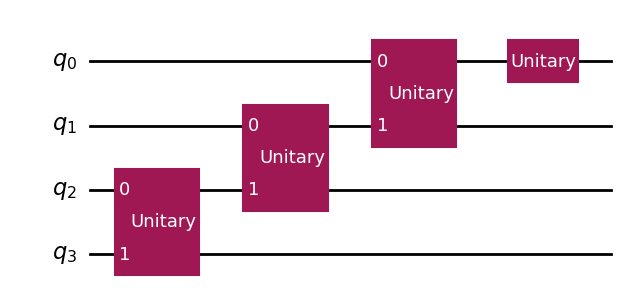

In [63]:
U_psi.draw('mpl')


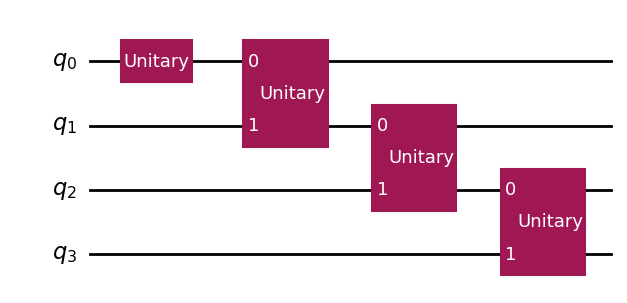

In [55]:
U_phi_dagger.draw('mpl')